In [63]:
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [106]:
scaler = MinMaxScaler(feature_range=(0,1))
def crypto( data, interval="1d"):
    data_complete = yf.download(data, interval=interval)
    data = scaler.fit_transform(data_complete["Adj Close"])
    return data, data_complete.index


def create_sequence(data, sequence_length=60):
    X,y = [], []
    for i in range(len(data)- sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def trainning(data):
    X, y = create_sequence(data=data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test), verbose=1)

    y_pred = model.predict(X_test)

    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    return model, y_test_rescaled, y_pred_rescaled, X_test, y_test


def predict_next_week(model, data, num_days, sequence_length=60):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)

    
    predicted_prices = []

    for _ in range(num_days):
        predicted_price =model.predict(last_sequence)
        predicted_prices.append(predicted_price[0,0])

        last_sequence = np.append(last_sequence[:, 1:, :], predicted_price.reshape(1,1,1), axis=1)
    
    predicted_prices_rescaled = scaler.inverse_transform(np.array(predicted_prices).reshape(-1,1))

    return predicted_prices_rescaled




[*********************100%***********************]  1 of 1 completed


Epoch 1/100
64/64 [==============================] - 4s 25ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 2/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 7.0949e-04
Epoch 3/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 7.4838e-04
Epoch 4/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 6.7830e-04
Epoch 5/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 5.6300e-04
Epoch 6/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 5.3074e-04
Epoch 7/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 5.5747e-04
Epoch 8/100
64/64 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 5.2598e-04
Epoch 9/100
64/64 [==============================] - 1s 13ms/step - loss: 8.8465e-04 - val_loss: 4.9891e-04
Epoch 10/100
64/64 [==============================] - 1s 14ms/st

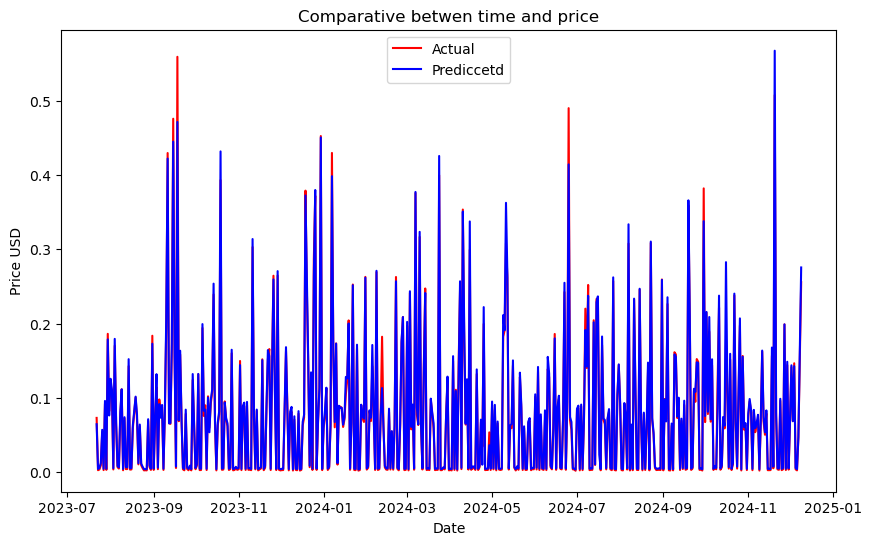

In [107]:
data, data_complete = crypto(data = 'DOGE-USD')
model, y_test_rescaled, y_pred_rescaled, X_test, y_test = trainning(data = data)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
std_rmse = np.std(rmse)
print(std_rmse)

prediction_dates = data_complete[-len(y_test_rescaled):]

plt.figure(figsize=(10,6))
plt.plot(prediction_dates, y_test_rescaled, label='Actual', c='r')
plt.plot(prediction_dates, y_pred_rescaled, label='Prediccetd', c='b')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.title('Comparative betwen time and price')
plt.legend()
plt.show()

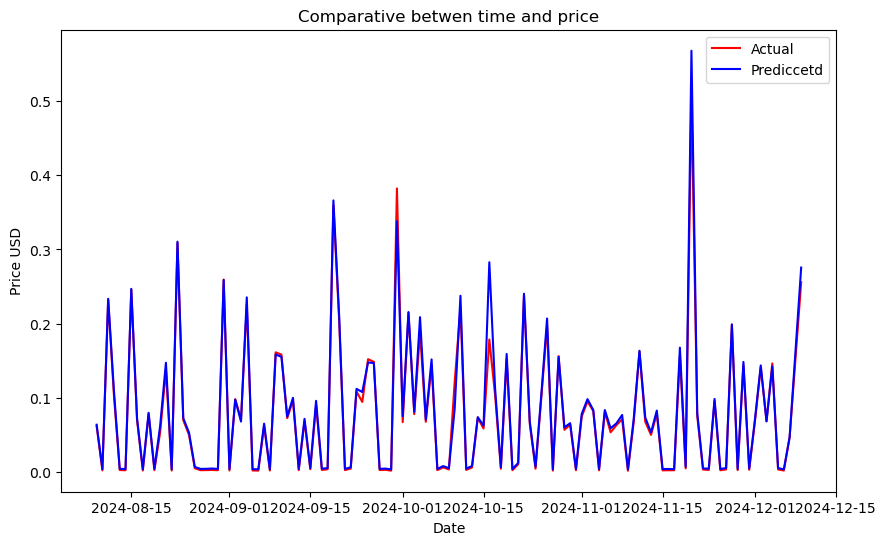

In [108]:
two_months = pd.to_datetime('today') - pd.DateOffset(months=4)
recent_dates = prediction_dates[prediction_dates>= two_months]

recent_y_test_rescaled = y_test_rescaled[-len(recent_dates):]
recent_y_pred_rescaled = y_pred_rescaled[-len(recent_dates):]

plt.figure(figsize=(10,6))
plt.plot(recent_dates, recent_y_test_rescaled, label='Actual', c='r')
plt.plot(recent_dates, recent_y_pred_rescaled, label='Prediccetd', c='b')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.title('Comparative betwen time and price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 23ms/step
[[0.45093668]
 [0.44316706]
 [0.43226057]
 [0.4219249 ]
 [0.41427293]
 [0.40964875]
 [0.4071824 ]]


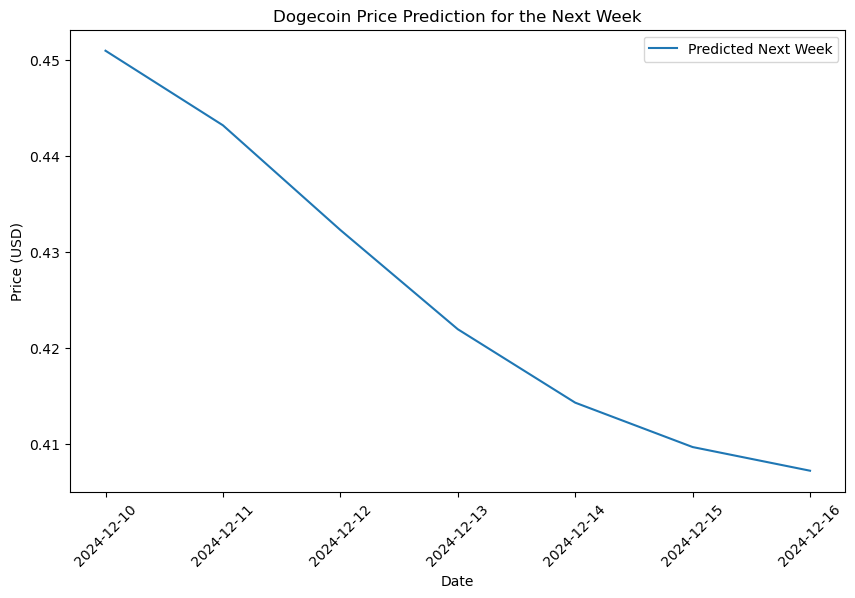

In [111]:
num_days = 7
predict_nw = predict_next_week(model=model, data=data, num_days=num_days)

# Get the last date of the complete data
last_date = pd.to_datetime(data_complete[-1])

# Adjust the number of periods to match the number of predicted prices (10 days)
next_week_dates = pd.date_range(last_date, periods= num_days+1, freq='D')[1:]  # This generates 10 dates

print(predict_nw)

# Plot the predictions for the next week
plt.figure(figsize=(10, 6))
plt.plot(next_week_dates, predict_nw, label='Predicted Next Week')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Dogecoin Price Prediction for the Next Week')
plt.legend()
plt.xticks(rotation=45)
plt.show()

[*********************100%***********************]  1 of 1 completed


Epoch 1/100
92/92 [==============================] - 4s 22ms/step - loss: 0.0064 - val_loss: 4.3149e-04
Epoch 2/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 3.8679e-04
Epoch 3/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 4.6380e-04
Epoch 4/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 3.3680e-04
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 4.4593e-04
Epoch 6/100
92/92 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 2.6639e-04
Epoch 7/100
92/92 [==============================] - 1s 13ms/step - loss: 9.0675e-04 - val_loss: 2.6356e-04
Epoch 8/100
92/92 [==============================] - 1s 13ms/step - loss: 9.4458e-04 - val_loss: 2.4345e-04
Epoch 9/100
92/92 [==============================] - 1s 13ms/step - loss: 9.4596e-04 - val_loss: 2.4527e-04
Epoch 10/100
92/92 [==============================] 

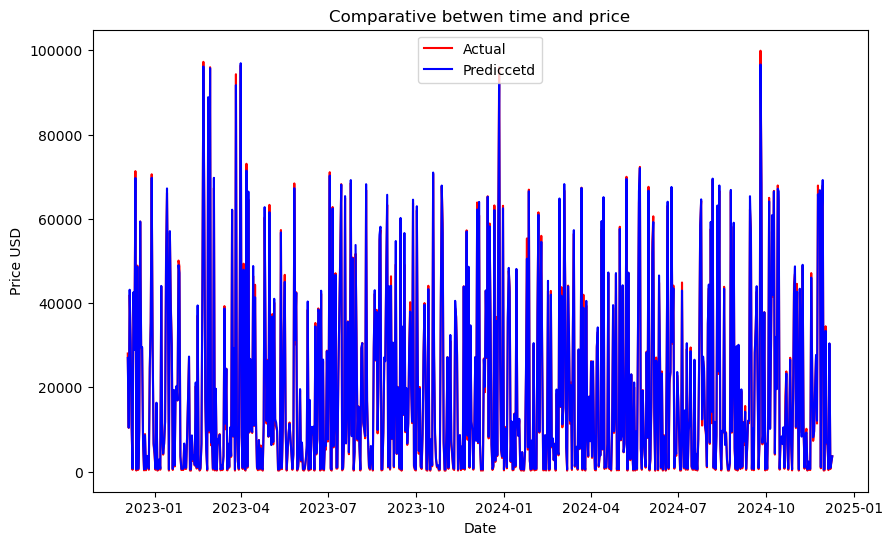

In [112]:
data, data_complete = crypto(data = 'BTC-USD')
model, y_test_rescaled, y_pred_rescaled, X_test, y_test = trainning(data = data)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
std_rmse = np.std(rmse)
print(std_rmse)

prediction_dates = data_complete[-len(y_test_rescaled):]

plt.figure(figsize=(10,6))
plt.plot(prediction_dates, y_test_rescaled, label='Actual', c='r')
plt.plot(prediction_dates, y_pred_rescaled, label='Prediccetd', c='b')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.title('Comparative betwen time and price')
plt.legend()
plt.show()

716.7814


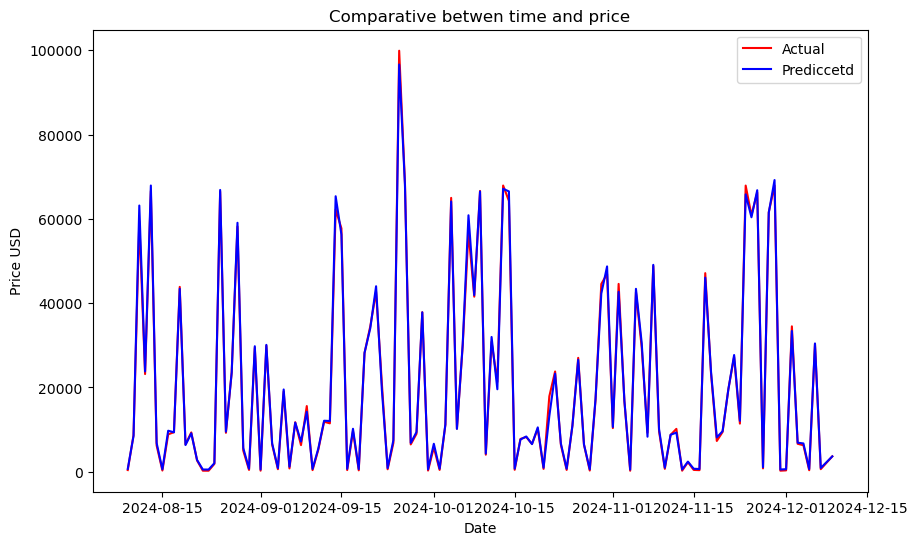

In [115]:
two_months = pd.to_datetime('today') - pd.DateOffset(months=4)
recent_dates = prediction_dates[prediction_dates>= two_months]

recent_y_test_rescaled = y_test_rescaled[-len(recent_dates):]
recent_y_pred_rescaled = y_pred_rescaled[-len(recent_dates):]

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

std_rmse = np.std(rmse)
print(std_rmse)

plt.figure(figsize=(10,6))
plt.plot(recent_dates, recent_y_test_rescaled, label='Actual', c='r')
plt.plot(recent_dates, recent_y_pred_rescaled, label='Prediccetd', c='b')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.title('Comparative betwen time and price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 26ms/step
[[99140.28 ]
 [98675.766]
 [98365.14 ]
 [98166.43 ]
 [98018.26 ]
 [97885.09 ]
 [97753.57 ]
 [97621.24 ]
 [97488.92 ]
 [97357.625]
 [97227.8  ]
 [97099.46 ]
 [96972.48 ]
 [96846.75 ]
 [96722.22 ]
 [96598.9  ]
 [96476.83 ]
 [96356.06 ]
 [96236.64 ]
 [96118.61 ]
 [96001.97 ]
 [95886.75 ]
 [95772.945]
 [95660.555]
 [95549.55 ]
 [95439.92 ]
 [95331.66 ]
 [95224.72 ]
 [95119.12 ]
 [95014.82 ]
 [94911.8  ]
 [94810.04 ]
 [94709.53 ]
 [94610.234]
 [94512.15 ]
 [94415.25 ]
 [94319.516]
 [94224.94 ]
 [94131.484]
 [94039.15 ]
 [93947.92 ]
 [93857.77 ]
 [93768.69 ]
 [93680.66 ]
 [93593.66 ]
 [93507.69 ]
 [93422.72 ]
 [93338.75 ]
 [93255.74 ]
 [93173.7  ]
 [93092.62 ]
 [93012.47 ]
 [92933.234]
 [92854.91 ]
 [92777.484]
 [92700.945]
 [92625.28 ]
 [92550.46 ]
 [92476.49 ]
 [92403.37 ]
 [92331.06 ]
 [92259.56 ]
 [92188.875]
 [92118.98 ]
 [92049.86 ]
 [91981.516]
 [91913.92 ]
 [91847.08 ]
 [91780.98 ]
 [91715.6  ]
 [91650.95 ]
 [91587.016]
 [91523.77 ]

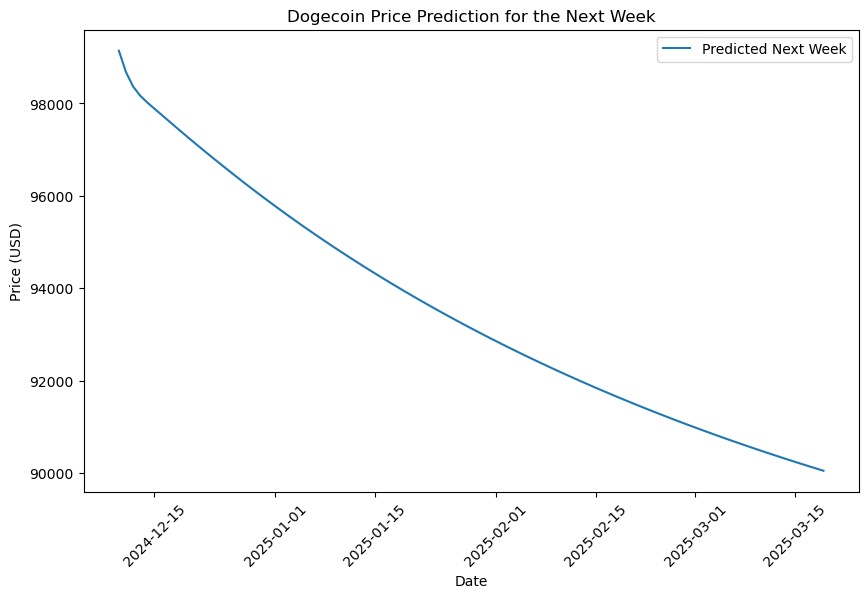

In [118]:
num_days = 100
predict_nw = predict_next_week(model=model, data=data, num_days=num_days)

# Get the last date of the complete data
last_date = pd.to_datetime(data_complete[-1])

# Adjust the number of periods to match the number of predicted prices (10 days)
next_week_dates = pd.date_range(last_date, periods= num_days+1, freq='D')[1:]  # This generates 10 dates

print(predict_nw)

# Plot the predictions for the next week
plt.figure(figsize=(10, 6))
plt.plot(next_week_dates, predict_nw, label='Predicted Next Week')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Dogecoin Price Prediction for the Next Week')
plt.legend()
plt.xticks(rotation=45)
plt.show()